# Primary outcome
* intubation 전후로 model 

# Secondary outcome: HR, MBP

* test set의 각 caseid 단위로 intubation 전후 HR, MBP 변화를 TSS median score 기준으로 잘 예측하는지, 변화율이 20% 넘어가는게 intubation을 예측하는지 살펴볼 수 있음
    * 방법1. del HR = eHR - nHR => TSS median 이상이면 대응되는 참값은 1, TSS medain 이하면 0 으로 AUROC 계산
    * 방법2. del HR = (eHR - nHR) / nHR > 20% 이면 1, 아니면 0 로 AUROC 계산

## Loading data (HR, MBP)

In [29]:
import os, pickle
import pandas as pd
import numpy as np

# loading vital data
file_path = '../Preprocess/vital_to_np'
df_preprocess = pickle.load(open('../Preprocess/cache/preprocess/df_preprocess_220115', 'rb'))
caseid_test = pickle.load(open('../DL_model/caseid_test', 'rb'))

dHRs, dMBPs = [], []
yHRs, yMBPs = [], []
TSS, yTSS = [], []
for caseid in caseid_test:
    vals = np.load(f'{file_path}/{caseid}.npz')
    
    eMBP = vals['MBP']
    nMBP = vals['nMBP']
    eHR = vals['HR']
    nHR = vals['nHR']
     
    if not np.mean(~np.isnan(eMBP)) or len(eMBP)==0:
        print(f'caseid {caseid} : empty eMBP')
        continue
    elif not np.mean(~np.isnan(nMBP)) or len(nMBP)==0:
        print(f'caseid {caseid} : empty nMBP')       
        continue
    elif not np.mean(~np.isnan(eHR)) or len(eHR)==0:
        print(f'caseid {caseid} : empty eHR')
        continue
    elif not np.mean(~np.isnan(nHR)) or len(nHR)==0: 
        print(f'caseid {caseid} : empty nHR')
        continue
    
    dHR = (np.nanmean(eHR) - np.nanmean(nHR)) 
    if np.isnan(dHR):
    rHR = dHR / np.nanmean(nHR)
    yhr = 1 if rHR >= 0.2 else 0
    yHRs.append(yhr)
    dHRs.append(dHR)
    
    dMBP = (np.nanmean(eMBP) - np.nanmean(nMBP)) 
    rMBP = dMBP / np.nanmean(nMBP)
    yMBP = 1 if rMBP >= 0.2 else 0
    yMBPs.append(yMBP)
    dMBPs.append(dMBP)
    
    tss = 1.57 - np.mean(vals['RFTN'][~np.isnan(vals['RFTN'])])/3
    ytss = 1 if tss > 0.238 else 0
    TSS.append(tss)
    yTSS.append(ytss)  

caseid 5689 : empty nMBP
caseid 5453 : empty nMBP
caseid 2966 : empty nMBP
caseid 5414 : empty eHR


## AUROC
방법1) dHR과 yTSS에 대해 AUC<br>
방법2) TSS와 yHRS에 대해 AUC

test set auroc: 0.498880,  test set auprc: 0.305826


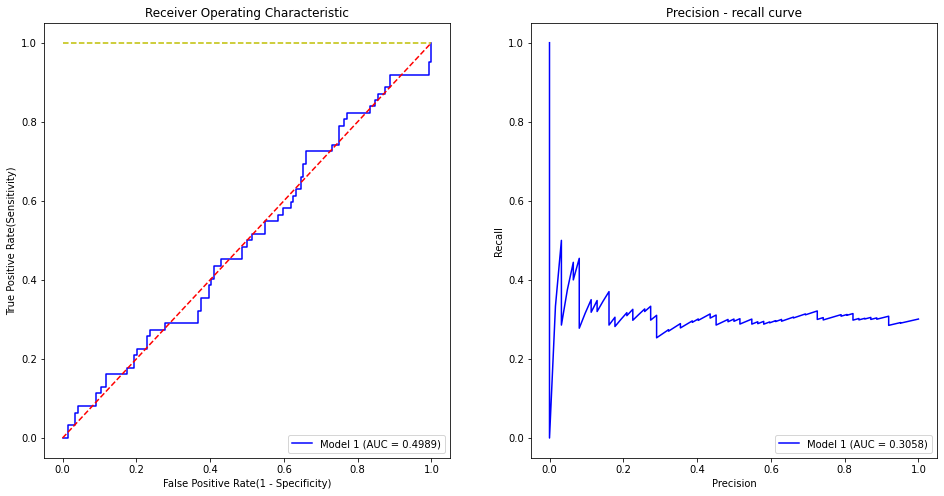

In [38]:
from sklearn.metrics import roc_curve, auc, r2_score, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt


# Model AUROC, AUPRC
false_positive_rate1, true_positive_rate1, threshold = roc_curve(yTSS, dHRs)
precision1, recall1, _ = precision_recall_curve(yTSS, dHRs)

roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
prc_auc1 = auc(recall1, precision1)
print('test set auroc: {:.6f},  test set auprc: {:.6f}'.format(roc_auc1, prc_auc1))


# plotting auprc
fig = plt.figure(figsize=(16,8))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')

ax1.plot(false_positive_rate1, true_positive_rate1, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc1)
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.legend(loc='lower right')

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - recall curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall1, precision1, 'b', label='Model 1 (AUC = %0.4f)'% prc_auc1)
ax2.legend(loc='lower right')
plt.show()

test set auroc: 0.483119,  test set auprc: 0.386488


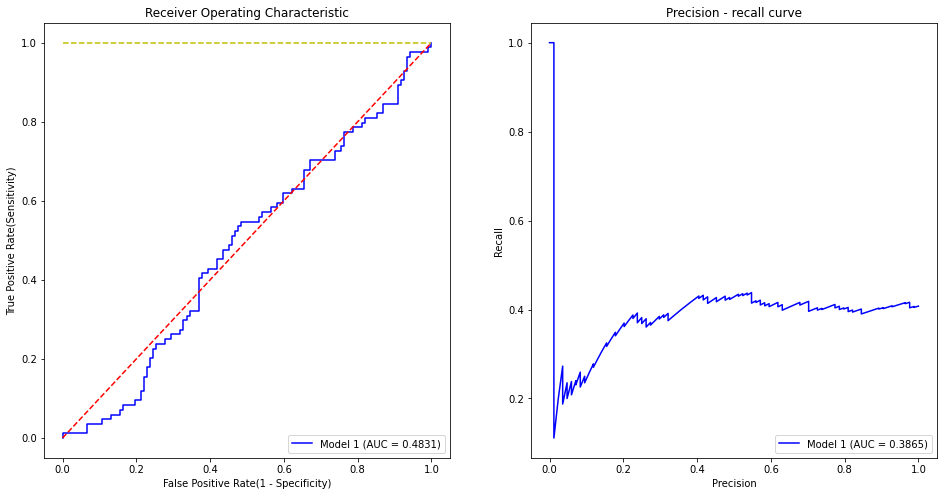

In [39]:
from sklearn.metrics import roc_curve, auc, r2_score, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt


# Model AUROC, AUPRC
false_positive_rate1, true_positive_rate1, threshold = roc_curve(yHRs, TSS)
precision1, recall1, _ = precision_recall_curve(yHRs, TSS)

roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
prc_auc1 = auc(recall1, precision1)
print('test set auroc: {:.6f},  test set auprc: {:.6f}'.format(roc_auc1, prc_auc1))


# plotting auprc
fig = plt.figure(figsize=(16,8))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')

ax1.plot(false_positive_rate1, true_positive_rate1, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc1)
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.legend(loc='lower right')

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - recall curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall1, precision1, 'b', label='Model 1 (AUC = %0.4f)'% prc_auc1)
ax2.legend(loc='lower right')
plt.show()

## Delong method

In [ ]:
from keras.models import model_from_json
import delong

#i for items / j for models
for j in range(3):
    load_path = loads[j]
    
    #model 부르기
    load_weight_path = load_path+'/weights.hdf5'

    print('loading model...', flush=True, end='')
    with open(load_path+"/model.json", 'r') as f_json:
        loaded_model_json = f_json.read()
    loaded_model = model_from_json(loaded_model_json)
    print('done')
    
    print('loading weights...', flush=True, end='')
    loaded_model.load_weights(load_weight_path)
    print('done')

    for i in range(3):
        result = 0 
        index=3*i+j
        x_test_model = x_tests[index]
        x = xs[i]
        y = ys[i]                
        
        y_pred = loaded_model.predict(x_test_model).flatten()
        
        #delong 계산하기
        actual = y
        preds_A = x
        preds_B = y_pred
        
        result = delong.delong_roc_test(actual, preds_A, preds_B)
        df_delong.iloc[i,j]=result

print(df_delong)        

# Model evaluation

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  

## Loading input

In [9]:
import numpy as np

SRATE = 100
LEN_INPUT = 20
OVERLAP = 10
LEN_PER_PRE = 60
LEN_PER_POST = 60

input_path = f"../DL_model/dataset/ne{LEN_PER_PRE}s-e{LEN_PER_POST}s-len{LEN_INPUT}-{OVERLAP}/"

x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
x_val = np.load(input_path+'x_val.npz', allow_pickle=True)['arr_0']
tss_train = np.load(input_path+'tss_train.npz')['arr_0']
tss_test = np.load(input_path+'tss_test.npz')['arr_0']
tss_val = np.load(input_path+'tss_val.npz')['arr_0']

## Loading model

In [4]:
from keras.models import model_from_json


load_path = '../DL_model/randomSearch/CISA/CNN_4layers_Reg_1fold_test200'
load_path+='/mae0.051_rmse0.074_batch=512,c1=64,c2=128,c3=128,c4=256,filt1=3,filt2=7,filt3=3,filt4=7,str1=1,str2=1,str3=2,str4=1, conv_double=True,globalpool=ave,dropout=0.5,dnodes=8,dropout=0'
load_weight_path = load_path+'/weights.hdf5'

print('loading model...', flush=True, end='')
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
loaded_model = model_from_json(loaded_model_json)
print('done')
print('loading weights...', flush=True, end='')
loaded_model.load_weights(load_weight_path)
print('done')

loading model...

2022-01-18 13:37:42.899655: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-18 13:37:44.702445: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30979 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0


done
loading weights...done


## CISA

train set auroc: 1.000000,  train set auprc: 1.000000


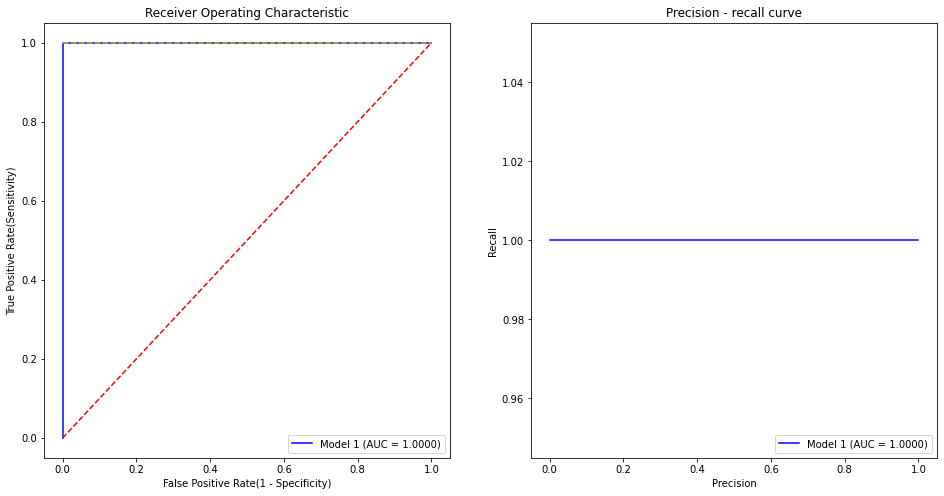

In [9]:
# loading input
SRATE = 100
LEN_INPUT = 20
OVERLAP = 10
LEN_PER_PRE = 60
LEN_PER_POST = 120

input_path = f"../DL_model/dataset/ne{LEN_PER_PRE}s-e{LEN_PER_POST}s-len{LEN_INPUT}-{OVERLAP}/"
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
cisa_test = np.load(input_path+'cisa_test.npz')['arr_0']


from sklearn.metrics import roc_curve, auc, r2_score, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

# model predict
y_pred = loaded_model.predict(x_test).flatten()
cisa_test_bin = cisa_test > 0

# Model AUROC, AUPRC
false_positive_rate1, true_positive_rate1, threshold = roc_curve(cisa_test_bin, y_pred/10)
precision1, recall1, _ = precision_recall_curve(cisa_test_bin, y_pred/10)

roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
prc_auc1 = auc(recall1, precision1)
print('train set auroc: {:.6f},  train set auprc: {:.6f}'.format(roc_auc1, prc_auc1))


# plotting auprc
fig = plt.figure(figsize=(16,8))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')

ax1.plot(false_positive_rate1, true_positive_rate1, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc1)
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.legend(loc='lower right')

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - recall curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall1, precision1, 'b', label='Model 1 (AUC = %0.4f)'% prc_auc1)
ax2.legend(loc='lower right')
plt.show()

### Model Evaluation - train set

train set auroc: 1.000000,  train set auprc: 1.000000


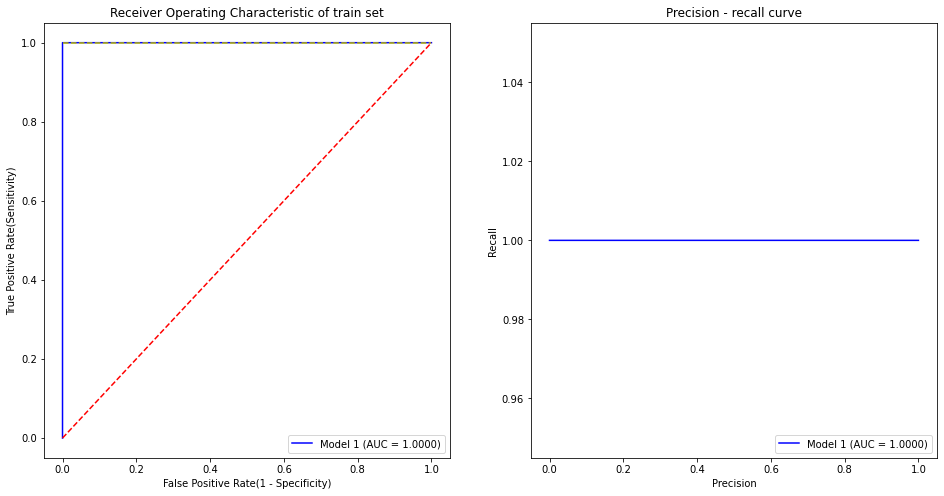

In [11]:
# loading input
SRATE = 100
LEN_INPUT = 20
OVERLAP = 10
LEN_PER_PRE = 60
LEN_PER_POST = 120

input_path = f"../DL_model/dataset/ne{LEN_PER_PRE}s-e{LEN_PER_POST}s-len{LEN_INPUT}-{OVERLAP}/"
x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
cisa_train = np.load(input_path+'cisa_train.npz')['arr_0']


from sklearn.metrics import roc_curve, auc, r2_score, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

# model predict
y_pred = loaded_model.predict(x_train).flatten()
cisa_train_bin = cisa_train > 0

# Model AUROC, AUPRC
false_positive_rate1, true_positive_rate1, threshold = roc_curve(cisa_train_bin, y_pred/10)
precision1, recall1, _ = precision_recall_curve(cisa_train_bin, y_pred/10)

roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
prc_auc1 = auc(recall1, precision1)
print('train set auroc: {:.6f},  train set auprc: {:.6f}'.format(roc_auc1, prc_auc1))


# plotting auprc
fig = plt.figure(figsize=(16,8))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic of train set')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')

ax1.plot(false_positive_rate1, true_positive_rate1, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc1)
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.legend(loc='lower right')

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - recall curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall1, precision1, 'b', label='Model 1 (AUC = %0.4f)'% prc_auc1)
ax2.legend(loc='lower right')
plt.show()

## TSS

### PPG + ECG

loading model...done
loading weights...done
train set auroc: 0.642236,  train set auprc: 0.417771


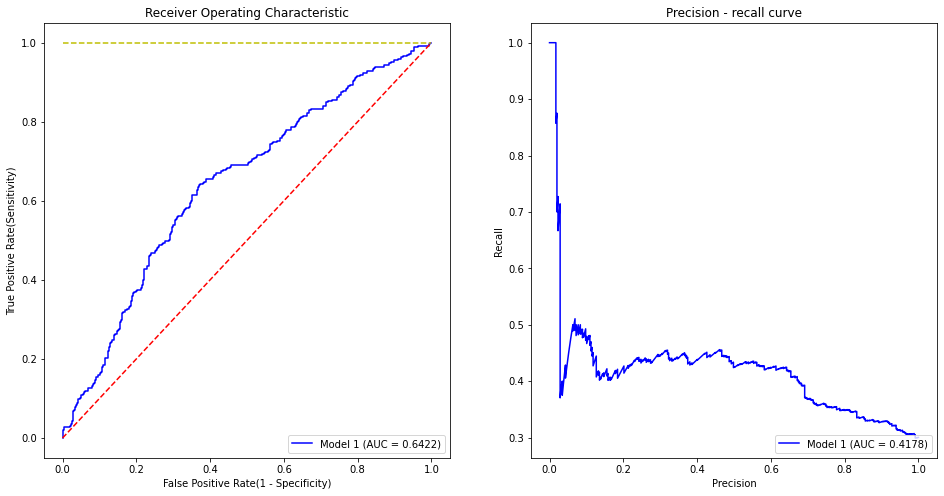

In [6]:
from keras.models import model_from_json
import numpy as np

load_path = '../DL_model/randomSearch/TSS/CNN_PPG+ECG_4layers_Reg_1fold_test200'
#load_path+='/mae0.084_rmse0.171_batch=512,c1=32,c2=32,c3=0,c4=0,filt1=5,filt2=3,filt3=0,filt4=0,str1=1,str2=1,str3=0,str4=0, conv_double=False,globalpool=ave,dropout=0.4,dnodes=8,dropout=0.5'
load_path+='/mae0.098_rmse0.151_batch=512,c1=64,c2=64,c3=0,c4=0,filt1=5,filt2=7,filt3=0,filt4=0,str1=2,str2=1,str3=0,str4=0, conv_double=False,globalpool=ave,dropout=0.2,dnodes=8,dropout=0.1'
load_weight_path = load_path+'/weights.hdf5'

print('loading model...', flush=True, end='')
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
loaded_model2 = model_from_json(loaded_model_json)
print('done')
print('loading weights...', flush=True, end='')
loaded_model2.load_weights(load_weight_path)
print('done')


# loading input
SRATE = 100
LEN_INPUT = 20
OVERLAP = 10
LEN_PER_PRE = 60
LEN_PER_POST = 60

input_path = f"../DL_model/dataset/ne{LEN_PER_PRE}s-e{LEN_PER_POST}s-len{LEN_INPUT}-{OVERLAP}/"
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
tss_test = np.load(input_path+'tss_test.npz')['arr_0']


from sklearn.metrics import roc_curve, auc, r2_score, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

# model predict
y_pred = loaded_model2.predict(x_test).flatten()
tss_test_bin = tss_test > 0

# Model AUROC, AUPRC
false_positive_rate1, true_positive_rate1, threshold = roc_curve(tss_test_bin, y_pred/10)
precision1, recall1, _ = precision_recall_curve(tss_test_bin, y_pred/10)

roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
prc_auc1 = auc(recall1, precision1)
print('test set auroc: {:.6f},  test set auprc: {:.6f}'.format(roc_auc1, prc_auc1))


# plotting auprc
fig = plt.figure(figsize=(16,8))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')

ax1.plot(false_positive_rate1, true_positive_rate1, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc1)
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.legend(loc='lower right')

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - recall curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall1, precision1, 'b', label='Model 1 (AUC = %0.4f)'% prc_auc1)
ax2.legend(loc='lower right')
plt.show()

### ECG

loading model...done
loading weights...done
train set auroc: 0.550258,  train set auprc: 0.336969


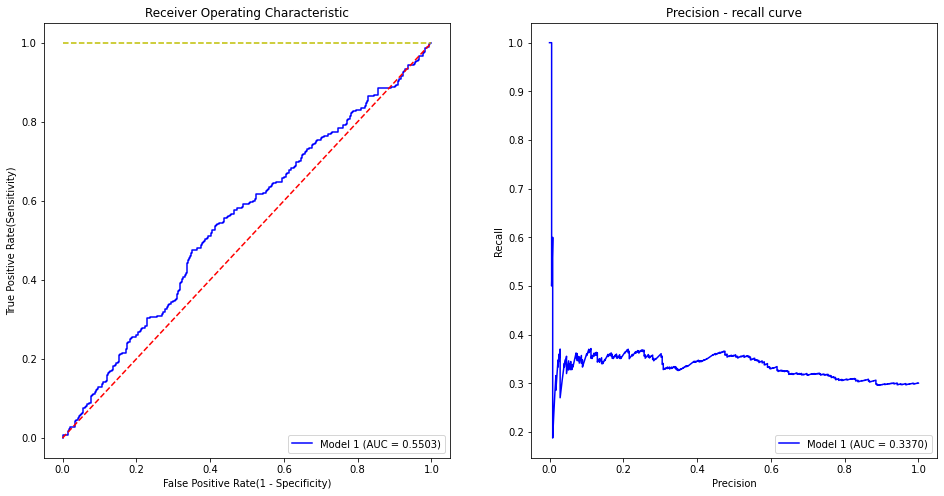

In [10]:
from keras.models import model_from_json
import numpy as np

load_path = '../DL_model/randomSearch/TSS/CNN_ECG_4layers_Reg_1fold_test200'
load_path+='/mae0.084_rmse0.171_batch=512,c1=32,c2=32,c3=0,c4=0,filt1=5,filt2=3,filt3=0,filt4=0,str1=1,str2=1,str3=0,str4=0, conv_double=False,globalpool=ave,dropout=0.4,dnodes=8,dropout=0.5'
#load_path+='/mae0.098_rmse0.151_batch=512,c1=64,c2=64,c3=0,c4=0,filt1=5,filt2=7,filt3=0,filt4=0,str1=2,str2=1,str3=0,str4=0, conv_double=False,globalpool=ave,dropout=0.2,dnodes=8,dropout=0.1'
load_weight_path = load_path+'/weights.hdf5'

print('loading model...', flush=True, end='')
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
loaded_model2 = model_from_json(loaded_model_json)
print('done')
print('loading weights...', flush=True, end='')
loaded_model2.load_weights(load_weight_path)
print('done')


# loading input
SRATE = 100
LEN_INPUT = 20
OVERLAP = 10
LEN_PER_PRE = 60
LEN_PER_POST = 60

input_path = f"../DL_model/dataset/ne{LEN_PER_PRE}s-e{LEN_PER_POST}s-len{LEN_INPUT}-{OVERLAP}/"
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
x_test_ecg = x_test[:,:,1:2]
tss_test = np.load(input_path+'tss_test.npz')['arr_0']


from sklearn.metrics import roc_curve, auc, r2_score, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

# model predict
y_pred = loaded_model2.predict(x_test_ecg).flatten()
tss_test_bin = tss_test > 0

# Model AUROC, AUPRC
false_positive_rate1, true_positive_rate1, threshold = roc_curve(tss_test_bin, y_pred)
precision1, recall1, _ = precision_recall_curve(tss_test_bin, y_pred)

roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
prc_auc1 = auc(recall1, precision1)
print('test set auroc: {:.6f},  test set auprc: {:.6f}'.format(roc_auc1, prc_auc1))


# plotting auprc
fig = plt.figure(figsize=(16,8))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')

ax1.plot(false_positive_rate1, true_positive_rate1, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc1)
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.legend(loc='lower right')

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - recall curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall1, precision1, 'b', label='Model 1 (AUC = %0.4f)'% prc_auc1)
ax2.legend(loc='lower right')
plt.show()

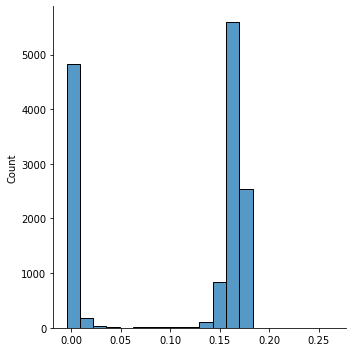

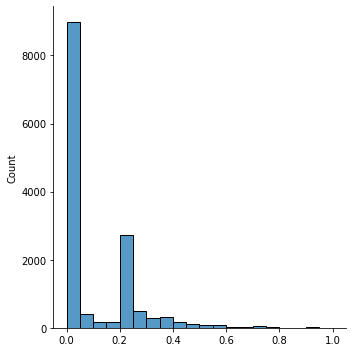

In [24]:
import seaborn as sns

tss_test = np.load(input_path+'tss_test.npz')['arr_0']
tss_train = np.load(input_path+'tss_train.npz')['arr_0']

sns.displot(loaded_model2.predict(x_train).flatten(), bins=20)
sns.displot(tss_train[tss_train<1], bins=20)

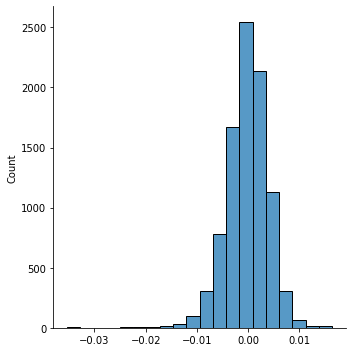

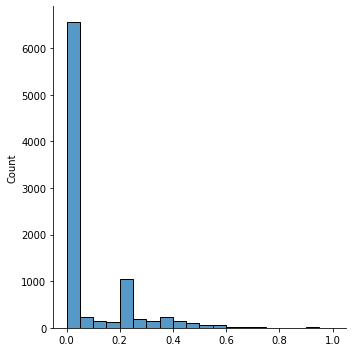

In [12]:
import seaborn as sns

tss_test = np.load(input_path+'tss_test.npz')['arr_0']
tss_train = np.load(input_path+'tss_train.npz')['arr_0']

sns.displot(loaded_model2.predict(x_train[:,:,1:2]).flatten(), bins=20)
sns.displot(tss_train[tss_train<1], bins=20)

In [14]:
np.mean(tss_train>0.4)

0.04729064039408867

2022-02-04 16:18:07.967350: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-02-04 16:18:08.554538: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


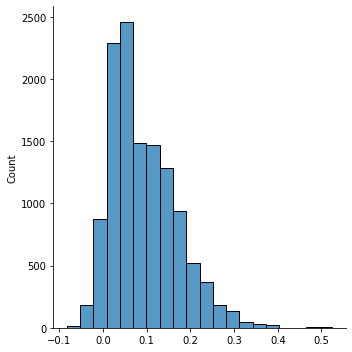

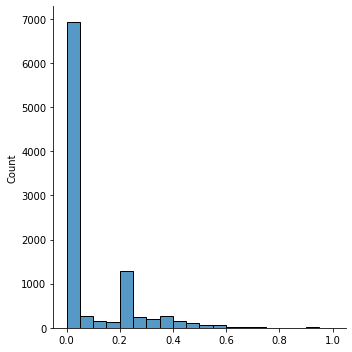

In [6]:
import seaborn as sns
import numpy as np

SRATE = 100
LEN_INPUT = 20
OVERLAP = 10
LEN_PER_PRE = 60
LEN_PER_POST = 60

input_path = f"../DL_model/dataset/ne{LEN_PER_PRE}s-e{LEN_PER_POST}s-len{LEN_INPUT}-{OVERLAP}/"

x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
x_val = np.load(input_path+'x_val.npz', allow_pickle=True)['arr_0']
tss_train = np.load(input_path+'tss_train.npz')['arr_0']
tss_test = np.load(input_path+'tss_test.npz')['arr_0']
tss_val = np.load(input_path+'tss_val.npz')['arr_0']

sns.displot(model.predict(np.concatenate((x_train,x_val, x_test), axis=0)).flatten(), bins=20)
sns.displot(tss_train[tss_train<1], bins=20)

# Plotting ROC curve

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc, r2_score
import matplotlib.pyplot as plt


false_positive_rate, true_positive_rate, threshold = roc_curve(y1, x_HR)
roc_auc_HR = auc(false_positive_rate, true_positive_rate)
print('HR test set auroc:', roc_auc_HR)

false_positive_rate, true_positive_rate, threshold = roc_curve(y2, x_MBP)
roc_auc_MBP = auc(false_positive_rate, true_positive_rate)
print('MBP test set auroc:', roc_auc_MBP)

# plotting
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve of MBP, HR')
plt.legend(loc="lower right")
plt.show()

# Prospective validation

In [1]:
# loading model
from keras.models import model_from_json
import os, sys
import tensorflow as tf
import statsmodels.api as sm
import numpy as np
import pandas as pd


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  

def best_model_path(models_dir):
    roc_list = []
    model_list = os.listdir(models_dir)
    for f_model in model_list:
        if f_model[0:3]=='roc':
            roc_list.append(f_model[3:9])
        else:
            roc_list.append(0)


    roc_list = np.array(roc_list)
    return os.path.join(models_dir,model_list[np.argmax(roc_list)])

with tf.device('/gpu:0'):
    models_dir = '../DL_model/randomSearch/TSS/CNN_4layers_Reg_1fold_test300'
    load_path = best_model_path(models_dir)
    load_weight_path = load_path+'/weights.hdf5'

    print('best model:', load_path)
    print('loading model...', flush=True, end='')
    with open(load_path+"/model.json", 'r') as f_json:
        model = model_from_json(f_json.read())
    print('done')
    print('loading weights...', flush=True, end='')
    model.load_weights(load_weight_path)
    print('done')

best model: ../DL_model/randomSearch/TSS/CNN_4layers_Reg_1fold_test300/mae0.113_rmse0.151_batch=1024,c1=64,c2=64,c3=0,c4=0,filt1=7,filt2=5,filt3=0,filt4=0,str1=1,str2=2,str3=0,str4=0, conv_double=True,globalpool=ave,dropout=0.5,dnodes=0,dropout=0
loading model...

2022-02-04 16:10:45.145992: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-04 16:10:46.007117: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30910 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0


done
loading weights...done


In [ ]:
sys.path.append('../Preprocess/pyvital2/')
import itertools as it
import pandas as pd
import numpy as np
import random
import vitaldb
import arr
import pickle
import matplotlib.pyplot as plt
import scipy.stats


def lowess(y, f=0.2):
    x = np.arange(0, len(y))
    return sm.nonparametric.lowess(y, x, frac=f, it=0)[:, 1].T

def linear_connection(list, idx):
    '''
        피크 사이 wave를 모두 같은 length로 만들기 위한 함수
    '''
    int_idx = int(idx)
    return list[int_idx] + (list[int_idx+1] - list[int_idx]) * (idx - int_idx)

SRATE = 100
LEN_INPUT = 20
OVERLAP = 10

# create saving folder
file_path = "../Preprocess/cache/peaks/full_vital"
if not os.path.exists(file_path):
    os.mkdir(file_path)

# dataframe of patient information    
df = pd.read_csv("https://api.vitaldb.net/cases")

# target patients' caseids
caseids = list(vitaldb.caseids_tiva & set(df.loc[df['ane_type'] == 'General', 'caseid']))

# tracks to extract / VENT_SET_TV -> VENT_INSP_TM, SET_INSP_TM
track_names = ["SNUADC/ECG_II", "SNUADC/PLETH", "Solar8000/VENT_INSP_TM", "Primus/SET_INSP_TM", "Orchestra/PPF20_CE", "Orchestra/RFTN20_CE"] #, "Solar8000/NIBP_MBP", "Solar8000/ART_MBP", "Solar8000/HR"]


cnt = 0
for caseid in caseids[:]:
    cnt = cnt + 1
    print(f'{cnt}/{len(caseids)}({caseid})', end='...')
    
    
    if os.path.exists(f'../Preprocess/cache/full_vital/{caseid}.npz'):
        print('already exists')
        continue
    
    
    x_input = []
    y_predict = []
    y_tss = []
    y_cisa = []    

    # get vital file and save as numpy
    vf = vitaldb.VitalFile(caseid, track_names)
    vals = vf.to_numpy(track_names, interval=1/SRATE)
    
    # vent_insp_tm
    if not np.mean(~np.isnan(vals[:,2])):
        if not np.mean(~np.isnan(vals[:,3])):
            print(f'no valid data for insp_tm')
            continue
        intu = vals[:,3]
    else:
        intu = vals[:,2]

    peak_path = f'../Preprocess/cache/peaks/full_vital/{caseid}.npz'
    # 100Hz PPG의 peak detection
    print('detecting PPG, ECG peak...', end='')
    if os.path.exists(peak_path):
        vital = np.load(peak_path, allow_pickle=True)
        _, ppg_peak = vital['PPG']
        ecg_peak = vital['ECG']
    else:
        min_ppg, ppg_peak = arr.detect_peaks((pd.DataFrame(vals[:,1]).fillna(method='ffill').fillna(method='bfill').values.flatten()), 100)
        ecg_peak = arr.detect_qrs((pd.DataFrame(vals[:,0]).fillna(method='ffill').fillna(method='bfill').values.flatten()),100)
        np.savez(peak_path, ECG = ecg_peak, PPG = (min_ppg, ppg_peak))
        
    ppg_peak = np.array([ppg_peak])
    ecg_peak = np.array([ecg_peak])
    print('done')
    
    
    # 각 window마다 전처리 후 모델에 값을 집어넣어 계산
    n_window = (len(vals[:,0])//SRATE-LEN_INPUT)//OVERLAP + 1
    for i in range(n_window-1):
        
        print('input {} ...'.format(i), end='')    
        bool_process = False
        frac = 0.2 # lowess fraction 계수
        
        
        # 전처리 과정
        while True:
            start_idx = i*OVERLAP*SRATE # 2500i
            end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 2500i + 5000


            seg_ppg, seg_ecg = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)] 
            seg_ppg = np.copy(vals[:,1][start_idx:end_idx])
            seg_ecg = np.copy(vals[:,0][start_idx:end_idx])
            
            
            #seg_ppg = seg_ppg - lowess(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), frac)
            #seg_ecg = seg_ecg - lowess(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), frac)

            ### 1. 결측치 처리 ###              
            # df.isnull().sum() 하면 더 간단하게 가능하나 애초에 NRS에 해당하는 vital data가 120초 보다 짧은 경우
            nan_ppg_list = np.isnan(seg_ppg)
            nan_ecg_list = np.isnan(seg_ecg)
            nan_ppg_perc = np.sum(nan_ppg_list) / LEN_INPUT / SRATE
            nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE

            # ECG, PPG 둘다 결측치인 부분
            nan_both_perc = 0
            for j in range(len(seg_ppg)):
                if nan_ppg_list[j] and  nan_ecg_list[j]:
                    nan_both_perc += 1
            nan_both_perc /= (LEN_INPUT*SRATE)

            # segment의 결측치 비율 정보
            nan_info = [nan_ppg_perc, nan_ecg_perc, nan_both_perc]

            # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
            if nan_ppg_perc > 0.2 or nan_ecg_perc > 0.2:
                print('nan out...', end='')
                break



            ### 2. Noise 처리 ###
            # 10초 segment 내의 ppg, ecg peak idx
            #seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
            idx_ppg_peak = ppg_peak[(start_idx<=ppg_peak) & (ppg_peak<end_idx)] - start_idx
            idx_ecg_peak = ecg_peak[(start_idx<=ecg_peak) & (ecg_peak<end_idx)] - start_idx

            # peak가 5개 이하는 noise가 많이 낀 상황 (20초 구간 중 peak가 18초 이상 없으면 문제 -> 즉 peak 개수 범위는 18/2 ~ 18/0.4)
            # 따라서 peak가 18초 이상 있어야하고 이때 최소 peak 개수는 9개
            # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
            if len(idx_ppg_peak)<=9 or len(idx_ecg_peak)<=9:
                print('peak out...', end='')
                break


            # 10초 segment 내의 ppg, ecg peak value
            #print(len(seg_ppg), idx_ppg_peak)
            val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
            val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]

            # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
            bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
            bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]

            #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
            for k in range(len(bool_noise_ppg)):
                if not 40 < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 200:
                    bool_noise_ppg[k] = True
            for k in range(len(bool_noise_ecg)):
                if not 40 < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 200:
                    bool_noise_ecg[k] = True

            # 2.2 모양 이상한 noise
            # wave interval into same length(2s(500))
            len_wave = 2*SRATE
            norm_seg_ppg, norm_seg_ecg = [], []

            for k in range(len(bool_noise_ppg)):
                len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]

                # peak 사이 wave를 모두 같은 길이로 변환
                norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])

            for k in range(len(bool_noise_ecg)):
                len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]

                # peak 사이 wave를 모두 같은 길이로 변환
                norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])


            # wave interval 사이 correlation 계산 - PPG
            mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
            mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
            norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
            for k in range(len(bool_noise_ppg)):
                if np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1] < 0.9:
                    bool_noise_ppg[k] = True
            noise_ppg_perc = np.sum(bool_noise_ppg) / len(bool_noise_ppg)

            # wave interval 사이 correlation 계산 - ECG                
            mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
            mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
            norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
            for k in range(len(bool_noise_ecg)):
                if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.9:
                    bool_noise_ecg[k] = True
            noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)

            # segment의 noise 비율 정보
            noise_info = [noise_ppg_perc, noise_ecg_perc]

            # segment를 input으로 써도 되는지
            if nan_ppg_perc < 0.2 and nan_ecg_perc < 0.2 and noise_ppg_perc < 0.3 and noise_ecg_perc < 0.3:
                bool_process = True
                print('pass')
                break
            else:
                print('noise out...ppg{}, ecg{}'.format(noise_ppg_perc, noise_ecg_perc), end='')
                break

                
        rftn = vals[:,5][start_idx:end_idx]
        rftn = np.mean(rftn[~np.isnan(rftn)])
        tss = 1.57 - rftn / 3
        if tss < 0:
            tss = 0
        y_tss.append(tss)
        y_cisa.append(7 - rftn / 8)

        # 전처리 실패한 경우
        if not bool_process:
            print('failed')
            x_input.append(np.nan)
            y_predict.append(np.nan)
            continue
        
        # 전처리 통과한 경우
        else:
            ppg_inp = pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
            ecg_inp = pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
            
            # lowess filter 적용
            ppg_input = ppg_inp - lowess(ppg_inp)
            ecg_input = ecg_inp - lowess(ecg_inp)
            
            ppg_input = ppg_input - np.nanmean(ppg_input)
            ecg_input = ecg_input - np.nanmean(ecg_input)        
       
            x_input.append([ppg_input,ecg_input])
            y_predict.append(model.predict(np.array([ppg_input,ecg_input]).reshape(1,2000,2)).flatten()[0])
        
        
    np.savez(f'../Preprocess/cache/full_vital/{caseid}.npz', x_input=x_input, y_predict=y_predict)


1/2699(3)...detecting PPG, ECG peak...done
input 0 ...pass
input 1 ...pass
input 2 ...pass
input 3 ...pass
input 4 ...pass
input 5 ...pass
input 6 ...pass
input 7 ...pass
input 8 ...pass
input 9 ...pass
input 10 ...pass
input 11 ...pass
input 12 ...pass
input 13 ...pass
input 14 ...pass
input 15 ...pass
input 16 ...pass
input 17 ...pass
input 18 ...pass
input 19 ...pass
input 20 ...pass
input 21 ...pass
input 22 ...pass
input 23 ...pass
input 24 ...pass
input 25 ...pass
input 26 ...pass
input 27 ...pass
input 28 ...pass
input 29 ...pass
input 30 ...pass
input 31 ...pass
input 32 ...pass
input 33 ...pass
input 34 ...pass
input 35 ...pass
input 36 ...pass
input 37 ...pass
input 38 ...pass
input 39 ...pass
input 40 ...noise out...ppg0.0, ecg0.3157894736842105failed
input 41 ...pass
input 42 ...pass
input 43 ...pass
input 44 ...pass
input 45 ...noise out...ppg0.047619047619047616, ecg0.47368421052631576failed
input 46 ...noise out...ppg0.1, ecg0.7368421052631579failed
input 47 ...pass
inpu

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


noise out...ppg1.0, ecg1.0failed
input 384 ...noise out...ppg1.0, ecg1.0failed
input 385 ...noise out...ppg1.0, ecg1.0failed
input 386 ...noise out...ppg1.0, ecg1.0failed
input 387 ...noise out...ppg1.0, ecg1.0failed
input 388 ...noise out...ppg1.0, ecg1.0failed
input 389 ...noise out...ppg1.0, ecg1.0failed
input 390 ...noise out...ppg1.0, ecg1.0failed
input 391 ...noise out...ppg1.0, ecg1.0failed
input 392 ...noise out...ppg1.0, ecg1.0failed
input 393 ...noise out...ppg1.0, ecg1.0failed
input 394 ...noise out...ppg1.0, ecg1.0failed
input 395 ...noise out...ppg1.0, ecg1.0failed
input 396 ...noise out...ppg1.0, ecg1.0failed
input 397 ...noise out...ppg1.0, ecg1.0failed
input 398 ...noise out...ppg1.0, ecg1.0failed
input 399 ...noise out...ppg1.0, ecg1.0failed
input 400 ...noise out...ppg0.8333333333333334, ecg1.0failed
input 401 ...noise out...ppg1.0, ecg1.0failed
input 402 ...noise out...ppg1.0, ecg1.0failed
input 403 ...noise out...ppg1.0, ecg1.0failed
input 404 ...noise out...ppg1.0,

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


detecting PPG, ECG peak...done
input 0 ...pass
input 1 ...pass
input 2 ...pass
input 3 ...pass
input 4 ...pass
input 5 ...pass
input 6 ...pass
input 7 ...pass
input 8 ...pass
input 9 ...pass
input 10 ...pass
input 11 ...pass
input 12 ...noise out...ppg0.375, ecg0.0failed
input 13 ...pass
input 14 ...pass
input 15 ...pass
input 16 ...pass
input 17 ...pass
input 18 ...pass
input 19 ...noise out...ppg0.17647058823529413, ecg0.3157894736842105failed
input 20 ...noise out...ppg0.4666666666666667, ecg0.65failed
input 21 ...pass
input 22 ...pass
input 23 ...pass
input 24 ...pass
input 25 ...pass
input 26 ...pass
input 27 ...pass
input 28 ...pass
input 29 ...pass
input 30 ...pass
input 31 ...pass
input 32 ...pass
input 33 ...pass
input 34 ...pass
input 35 ...pass
input 36 ...pass
input 37 ...pass
input 38 ...pass
input 39 ...pass
input 40 ...pass
input 41 ...pass
input 42 ...pass
input 43 ...pass
input 44 ...pass
input 45 ...pass
input 46 ...pass
input 47 ...pass
input 48 ...pass
input 49 ...p

In [3]:
y = pd.DataFrame(y_predict).fillna(method='ffill', axis=0).values.flatten()

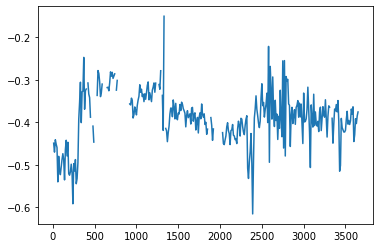

In [53]:
import matplotlib.pyplot as plt

plt.plot([10+10*i for i in range(len(y_predict))], y_predict)

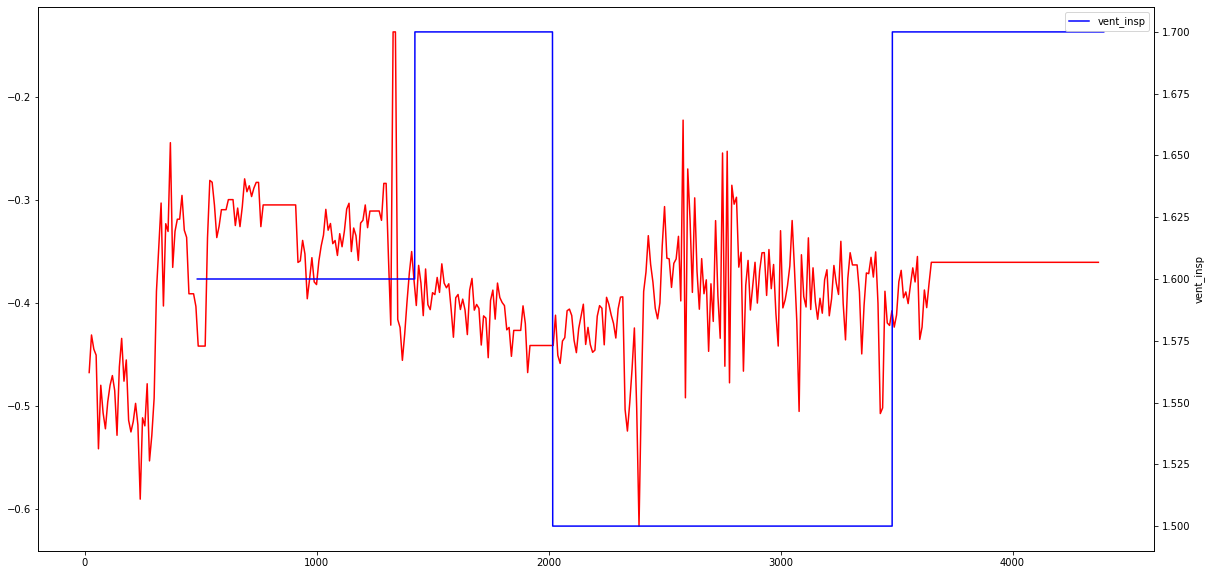

In [50]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.plot([1 * (10 + i * 10) for i in range(len(y_predict))], y, 'r', label='model prediction')
#ax1.set_xticks([i*5 for i in range(len(x_input))])

ax2 = ax1.twinx()
vent_insp = pd.DataFrame(intu).fillna(method='ffill', axis=0).values.flatten()
mask = [i*100 for i in range(len(vent_insp)//100)]
ax2.plot([i for i in range(len(vent_insp)//100)], vent_insp[mask], 'b', label='vent_insp')
ax2.set_ylabel('vent_insp')
ax2.set_xlabel('time (s)')
ax2.legend(loc='best')

plt.show()

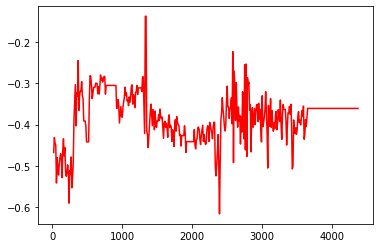

In [39]:
plt.plot([1 * (10 + i * 10) for i in range(len(y_predict))], y, 'r', label='model prediction')

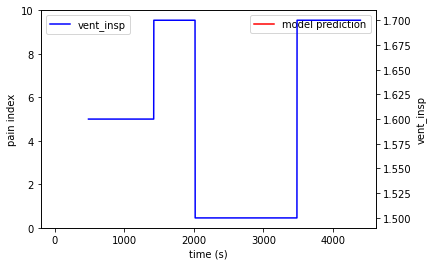

In [49]:
fig, ax1 = plt.subplots()

ax1.plot([1 * (10 + i * 10) for i in range(len(y_predict))], y, 'r', label='model prediction')
ax1.set_ylim(0, 10)
ax1.set_ylabel('pain index')
ax1.set_xlabel('time (s)')
ax1.legend(loc='best')


ax2 = ax1.twinx()
mask = [i*100 for i in range(len(vent_insp)//100)]
ax2.plot([i for i in range(len(vent_insp)//100)], vent_insp[mask], 'b', label='vent_insp')
ax2.set_ylabel('vent_insp')
ax2.set_xlabel('time (s)')
ax2.legend(loc='best')


In [16]:
10*len(y_predict), len(intu)/SRATE

(4370, 4394.05)

caseid: 3


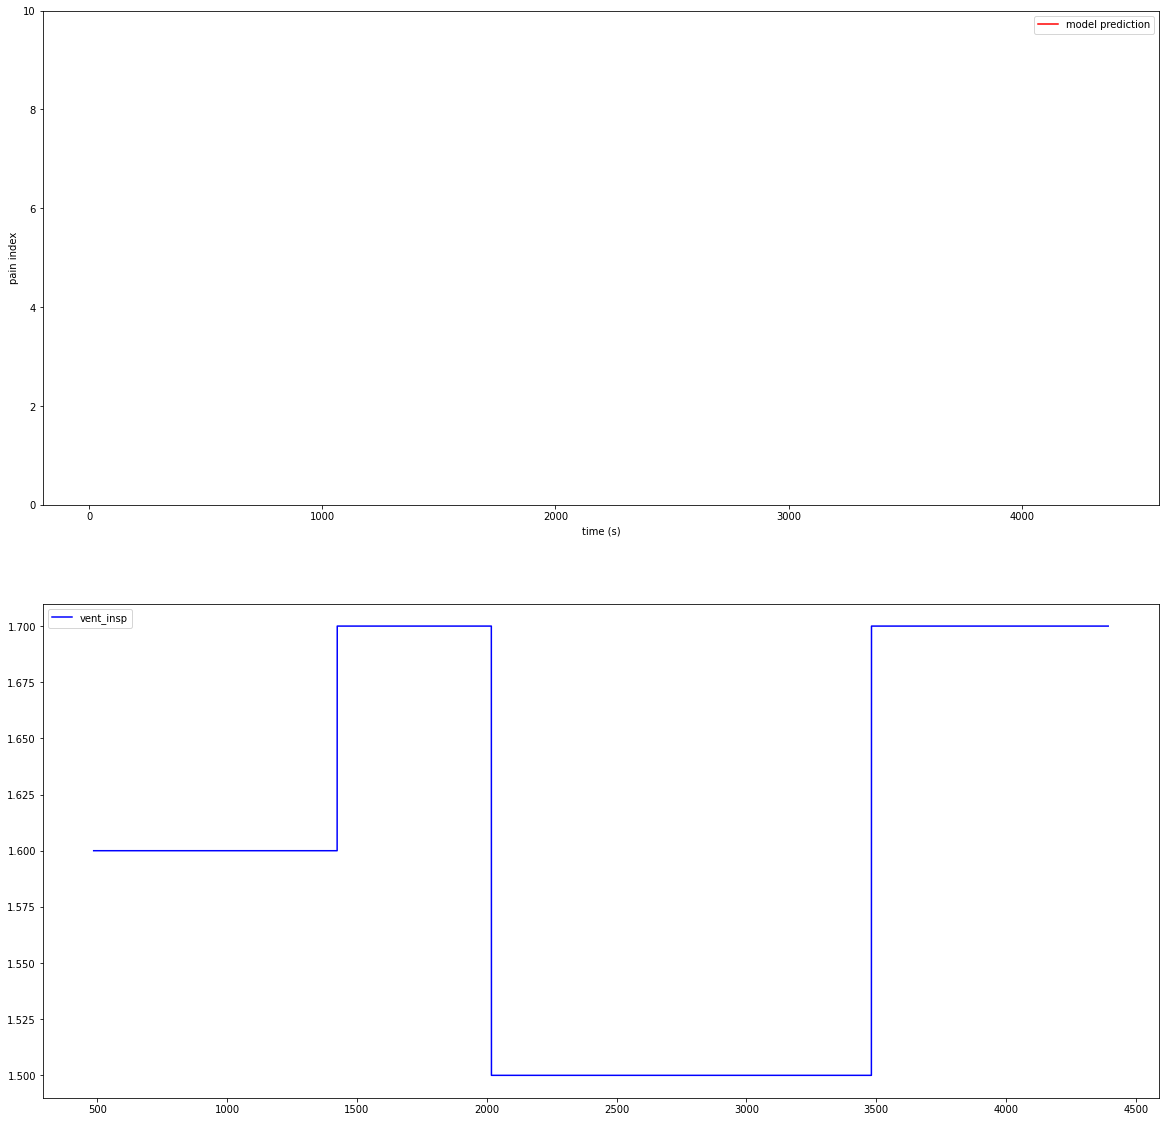

In [25]:
import matplotlib.pyplot as plt

mask = [~np.isnan(x).all() for x in x_input]
#y = np.copy(y_predict)
#y[np.isnan(y)] = -2


print(f'caseid: {caseid}')
# vent_insp_tm
vent_insp = pd.DataFrame(intu).fillna(method='ffill', axis=0).values.flatten()
if len(vent_insp) <= 1:
    print('no vent_insp')
#else:
    #vital_co2[vital_co2<=0] = 0


# plotting
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(2,1,1)
#ax1.plot([i*10 for i in range(len(x_input))], y*10, 'r', label='model prediction')
ax1.plot([1 * (10 + i * 10) for i in range(len(y_predict))], y, 'r', label='model prediction')
#ax1.set_xticks([i*5 for i in range(len(x_input))])
ax1.set_ylim(0, 10)
ax1.set_ylabel('pain index')
ax1.set_xlabel('time (s)')
ax1.legend(loc='best')


ax2 = fig.add_subplot(2,1,2)
ax2.plot([i/100 for i in range(len(vent_insp))], vent_insp, 'b', label='vent_insp')
#ax2.plot(vent_insp, 'b', label='vent_insp')

ax2.legend(loc='best')
#ax2.plot(np.reshape(ecg_samp,[-1,])

plt.show()